In [1]:
using Random
using LinearAlgebra
using FMMProject
using Plots
import FMMProject: Laplace2D

In [2]:
# Parameters
Random.seed!(1)
K = Laplace2D   # kernel
Nlist = [2^n for n in 12:2:22]
Ntest = 256      # number of test points
b = 128     # number of points per box (average)
P = 5       # interaction rank

5

In [3]:
errlist = []   # relative errors
tfmm = []      # time FMM 
tloop = []     # time naive algorithm

for N in Nlist
    points = rand(Point2D,N)
    qcharges = randn(N)
    qcharges /= norm(qcharges,1)  # normalize charges
    idxs  = rand(1:N,Ntest)

    # true potential
    loopstats = @timed [sum(K(points[i],y)*qy for (y,qy) in zip(points,qcharges)) for i in idxs]
    pot = loopstats.value
    looptime = loopstats.time / Ntest * N  # approximate total forward map time
    push!(tloop,looptime)
    # assemble FMM
    L = max(floor(Int64,log(4,N/b)+1),2)
    fmm = FMMLaplace2D(points,P,L);
    # compute fmm potential and error
    fmmstats = @timed fmm*qcharges
    fmmtime = fmmstats.time
    push!(tfmm,fmmtime)
    pot_approx = fmmstats.value
    pot_test = pot_approx[idxs]
    err = norm(real.(pot_test)-pot,Inf)/norm(pot,Inf)
    push!(errlist,err)
    #@info "" N err looptime fmmtime
end

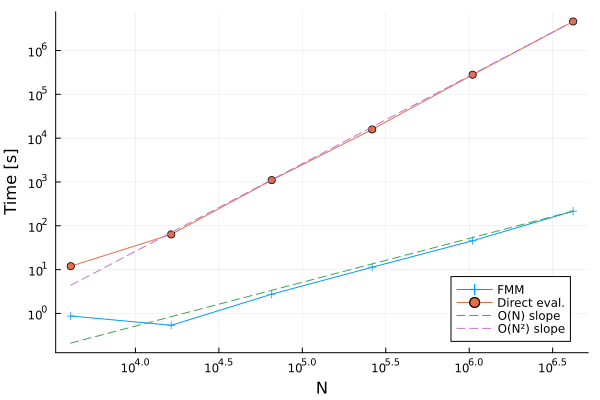

In [9]:
# Plot time
plot(Nlist,tfmm,xscale=:log10,yscale=:log10,shape=:auto,legend=:bottomright,label="FMM")
plot!(Nlist,tloop,shape=:auto,label="Direct eval.")
xlabel!("N")
ylabel!("Time [s]")
yticks!([10.0^i for i in -2:10])
xticks!([10.0^(0.5*i) for i in 7:13])

n_slope = Nlist 
n_slope *= tfmm[end]/n_slope[end]
n2_slope = Nlist .^ 2
n2_slope *= tloop[end]/n2_slope[end]
plot!(Nlist,n_slope,style=:dash,label="O(N) slope")
plot!(Nlist,n2_slope,style=:dash,label="O(N²) slope")


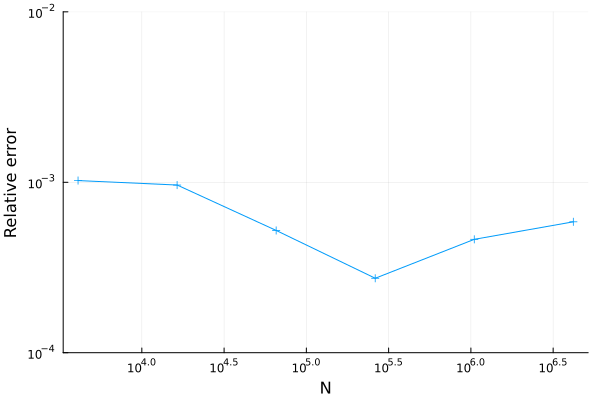

In [14]:
# Plot errors
plot(Nlist,errlist,xscale=:log10,yscale=:log10,shape=:auto,legend=false)
xlabel!("N")
ylabel!("Relative error")
xticks!([10.0^(0.5*i) for i in 7:13])
ylims!(1e-4,1e-2)